# Challenge Problem 3: Genome Wide Association Study

## Background:

(Adapted From BMI 704, Dr. Chirag Patel)

Genome-wide association studies (GWASs) are arguably the most significant biomedical advance in the last decade. Utilizing an observational case-control design, populations with disease are analytically compared to those without to discern patterns in differences in genetic variant, or single nucleotide polymorphism (SNP),frequencies in each of the respective populations. If statistically differences in SNP frequencies in cases vs
controls are found, one can conclude the SNP locus may have a causal relationship, implicating a gene, genetic region, or gene regulator in the disease of interest.

Analyzing GWASs provide lessons in observational research, including statistical association and multiple testing. They also provide a way to create hypotheses about biological basis of disease for further study. We will execute a GWAS analysis using data from the Wellcome Trust Case-Control Consortium (WTCCC) on Type 2 Diabetes, Type 1 Diabetes, Bipolar Disorder, Rheumatoid Arthritis, Chron's Disease and Hypertension versus 1,500 controls.

Note: There are standard tools and pipelines available to do this but we will do it the old fashioned way!

The Data is provided in separate directories under the primary WTCCC directory. The subdirectories are labeled as such:
* 58C : control population 1
* NBS : control population 2
* RA : rheumatoid arthritis
* T2D : type 2 diabetes
* T1D : type 1 diabetes
* CAD : coronary artery disease
* HT : hypertension
* CD : Crohn’s disease
* BD : bipolar disorder

All of the GWAS data is broken down per chromosome, 1-22 plus X and is written into the file name, as well as the disease. For example:

Affx_gt_ 58C _Chiamo_ 06 .tped.gz

Contains GWAS data for the 6th (06) chromosome on control population 1 (58C). The biggest files are chromosome 1 and 2 and smallest is 22.


Each row is a SNP (there are 6207 SNPs measured in Chromosome 22). The first through fourth columns denote the chromosome number, the second is the WTCCC snp_id (not to be confused with the rsid), the start coordinate (0), and the end coordinate. Thereafter, each column is a genotype (where each base is separated by a space character) for that SNP for each individual.

Additionally, each subdirectory also contains a ‘snps_info.tar.gz’, which contains the snp_id and rsID for each SNP for each chromosome. These files can enable you to map the WTCCC snp_id to the rsid, which is helpful to find the closest genes to a SNP (for example when you query the GWAS catalog).

In [6]:
import pandas as pd
import os
from os import path
import csv
import numpy as np
import time
from scipy.stats.distributions import chi2
from scipy.stats import chi2_contingency
from collections import Counter
import matplotlib.pyplot as plt


In [8]:
os.chdir('C:/Users/saketh/stuff/Medlytics/Week3Public')

In [10]:
## function to load the data file
def loadFile (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    fileName = 'BWSI_100set/' + disease + '/Affx_gt_' + disease + '_Chiamo_' + chrom_num + '.tped.gz'
    dat = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
    return(dat)

In [11]:
## function to load the data file
def loadSNPFile (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    fileName = 'BWSI_100set/' + disease + '/snps/snps_' + chrom_num
    dat = pd.read_csv(fileName, header=None, sep='\t')
    return(dat)

In [12]:
c1 = loadFile('58C', '22')
c2 = loadFile('NBS', '22')
snp_22 = pd.read_csv('BWSI_100set/58C/snps/snps_22', header=None, sep='\t')
t2d = loadFile('T2D', '22')

c1_head = c1.iloc[:, :4]
c1 = c1.iloc[:, 4:]
c2_head = c2.iloc[:, :4]
c2 = c2.iloc[:, 4:]
t2d_head = t2d.iloc[:, :4]
t2d = t2d.iloc[:, 4:]

In [13]:
len(t2d)

100

In [14]:
snp_short = snp_22.iloc[:, 3:]

snp_short = snp_short.rename(columns={3: 'snp', 4: 'rsid'})
snp_short.head()

,snp,rsid
0,SNP_A-4257236,rs134871
1,SNP_A-4272387,rs2223273
2,SNP_A-4282160,rs5751251
3,SNP_A-2290765,rs5758659
4,SNP_A-1910486,rs5758660


In [15]:
c1_head = c1_head.rename(columns={1: 'snp'})
c1_snp = c1_head.join(snp_short.set_index('snp'), on='snp')

c1_snp.head(10)

,0,snp,2,3,rsid
0,22,SNP_A-4234155,0,32056663,rs12484156
1,22,SNP_A-2223191,0,35653934,rs909486
2,22,SNP_A-4202732,0,32956968,rs1873230
3,22,SNP_A-1811354,0,46997362,rs7287281
4,22,SNP_A-1797179,0,32955711,rs1003935
5,22,SNP_A-1848186,0,34009951,rs2272789
6,22,SNP_A-4300107,0,32474498,rs17807797
7,22,SNP_A-2066692,0,22147891,rs5759844
8,22,SNP_A-1884396,0,26701485,rs5762425
9,22,SNP_A-4223629,0,43534919,rs132450


In [16]:
t2d_head.head(10)

,0,1,2,3
0,22,SNP_A-4234155,0,32056663
1,22,SNP_A-2223191,0,35653934
2,22,SNP_A-4202732,0,32956968
3,22,SNP_A-1811354,0,46997362
4,22,SNP_A-1797179,0,32955711
5,22,SNP_A-1848186,0,34009951
6,22,SNP_A-4300107,0,32474498
7,22,SNP_A-2066692,0,22147891
8,22,SNP_A-1884396,0,26701485
9,22,SNP_A-4223629,0,43534919


In [25]:
t2d_snp1 = t2d.loc[0]
c1_snp1 = c1.loc[0]
c2_snp1 = c2.loc[0]

t2d_snp1 = t2d_snp1.to_string(header = None, index = None)
#t2d_snp1

c1_snp1 = c1_snp1.to_string(header = None, index = None)
#c1_snp1

c2_snp1 = c2_snp1.to_string(header = None, index = None)

In [26]:
Counter(list(t2d.loc[0]))

Counter({'C C': 298, 'C T': 933, 'T T': 768})

In [27]:
def getAlleleCounts (genotype):
    """
    genotype = "C C 	C T 	C T 	C T 	T T"
    Allele frequency:
    count the "Cs", and the "Ts"
    f_C = # of Cs
    f_T = # of T's
    """
    
    max_count = 0
    min_count = 0
    max_type = ''
    min_type = ''
    
    genotype = sorted(genotype.items())
    
#     if len(genotype) == 3:
    if genotype[0][1] > genotype[2][1]:
        max_count += genotype[0][1] * 2
        min_count += genotype[2][1] * 2
        max_type = genotype[0][0][0]
        min_type = genotype[2][0][0]
    else:
        max_count += genotype[2][1] * 2
        min_count += genotype[0][1] * 2
        max_type = genotype[2][0][0]
        min_type = genotype[0][0][0]

    max_count += genotype[1][1]
    min_count += genotype[1][1]
#     else:
#         if genotype[0][0][0] == genotype[0][0][2]:
#             max_type = genotype[0][0][0]
            
#             if max_type == genotype[1][0][0]:
#                 min_type = genotype[1][0][2]
#             else:
#                 min_type = genotype[1][0][0]
            
#             max_count += genotype[0][1] * 2
#             min_count += genotype[1][1]
#         else:
#             max_type = genotype[1][0][0]
            
#             if max_type == genotype[0][0][0]:
#                 min_type = genotype[0][0][2]
#             else:
#                 min_type = genotype[0][0][0]
            
#             max_count += genotype[1][1] * 2
#             min_count += genotype[0][1]
        
    return min_count, max_count, min_type, max_type


In [28]:
t2d_C, t2d_T = getAlleleCounts(t2d_snp1)
print(t2d_C, t2d_T)

c1_C, c1_T = getAlleleCounts(c1_snp1)
print(c1_C, c1_T)

c2_C, c2_T = getAlleleCounts(c2_snp1)
print(c2_C, c2_T)

AttributeError: 'str' object has no attribute 'items'

In [29]:
## compute Allele Frequency for the minor allele
def computeAlleleFrequency (f_min, f_max):
    """
    f_C = minor allele count
    f_T = major allele count
    minor_allele_frequency = f_C/ (f_C+f_T) 
    """
    
    minor_allele_frequency = f_min / (f_min + f_max)
    
    return (minor_allele_frequency)

In [30]:
t2d_min_f = computeAlleleFrequency(t2d_C, t2d_T)
c1_min_f = computeAlleleFrequency(c1_C, c1_T)
c2_min_f = computeAlleleFrequency(c2_C, c2_T)

print(t2d_min_f, c1_min_f, c2_min_f)

NameError: name 't2d_C' is not defined

## Hardy Weinberg Equilibrium

In [31]:
def getGenotypeCounts (genotype):
    """
    genotype = "C C 	C T 	C T 	C T 	T T"
    Allele frequency:
    count the "Cs", and the "Ts"
    f_C = # of Cs
    f_T = # of T's
    """
    
    gen_count = Counter(genotype)
    
    return gen_count
    

In [32]:
# test = t2d.to_dict('index')
# print(test[0].values())

In [33]:
t2dlist = list(t2d.to_dict('index')[2].values())

t2dlist

['G G',
 'G G',
 'A G',
 'G G',
 'G G',
 'G G',
 'A G',
 'A G',
 'G G',
 'A G',
 'A A',
 'A G',
 'G G',
 'G G',
 'G G',
 'A G',
 'A G',
 'G G',
 'A G',
 'A G',
 'A G',
 'A G',
 'A G',
 'A A',
 'A G',
 'G G',
 'A G',
 'G G',
 'G G',
 'A G',
 'G G',
 'A G',
 'A G',
 'G G',
 'G G',
 'A G',
 'A G',
 'A G',
 'A G',
 'G G',
 'G G',
 'G G',
 'G G',
 'A G',
 'G G',
 'A G',
 'G G',
 'A G',
 'A G',
 'G G',
 'G G',
 'G G',
 'A G',
 'A G',
 'G G',
 'A G',
 'G G',
 'G G',
 'G G',
 'G G',
 'A G',
 'G G',
 'G G',
 'A G',
 'G G',
 'G G',
 'A G',
 'G G',
 'G G',
 'A G',
 'G G',
 'A G',
 'G G',
 'A G',
 'A G',
 'G G',
 'G G',
 'G G',
 'G G',
 'A G',
 'G G',
 'G G',
 'A G',
 'A G',
 'G G',
 'G G',
 'G G',
 'A G',
 'A G',
 'G G',
 'A G',
 'G G',
 'A G',
 'A A',
 'A G',
 'A A',
 'A G',
 'A G',
 'G G',
 'G G',
 'G G',
 'G G',
 'G G',
 'G G',
 'A G',
 'G G',
 'G G',
 'A G',
 'A G',
 'A G',
 'G G',
 'G G',
 'A G',
 'A G',
 'A G',
 'A A',
 'A G',
 'G G',
 'A G',
 'G G',
 'G G',
 'G G',
 'A G',
 'A G',
 'G G',


In [34]:
t2dcount = Counter(t2dlist)
t2dcount = sorted(t2dcount.items())
t2dcount[0][1]

123

In [35]:
c_min, c_max, c_min_type, c_max_type = getAlleleCounts(getGenotypeCounts(t2dlist))
print(c_min, c_max, c_min_type, c_max_type)

1021 2977 A G


In [36]:
## Compute the Odds Ratio
## takes as input a 2X2  confusion matrix
## returns the odds ratio
def computeOR (a, b, c, d):
    
    OR = (a * d) / (b * c)
    
    return OR

In [37]:
OR = computeOR(t2d_C, t2d_T, c1_C, c1_T)
OR

NameError: name 't2d_C' is not defined

In [38]:
## Execute a chisq test to determine if the odds ratio is significant
## return the p-value from the chisq test
def getPValue (table):
    
    chi2, p_val, dof, ex = chi2_contingency(table)
    
    return p_val

In [39]:
table = ([[t2d_C, t2d_T],[c1_C, c1_T]])

print(table)

getPValue(table)

NameError: name 't2d_C' is not defined

In [40]:
## Function takes as input the minor allele frequency (p) and the population genotype counts
## returns the p-value from the chisq test
def HWEChiSq (p, counts):
    """
        |  CC | CT  | TT |
    BP  | 270 | 957 | 771|
    compute the HWE
      -- p = frequency of the C allele
      -- q = 1-p = frequency of the T allele
      -- if the population genotype is in Hardy Weinberg Equilibrium, we would expect the genotype frequencies to be
          CC = p^2*N 
          CT = 2pq*N 
          TT = q^2*N 
      -- to compute the deviation from HWE
         (observed - expected)^2 / expected
      -- do a chi.squared test to check if the deviation is significant
    """
    
    q = 1 - p
    
    obcc = counts[0][1]
    obct = counts[1][1]
    obtt = counts[2][1]
    
    total = obcc + obct + obtt
    
    ecc = p ** 2 * total
    ect = 2 * p * q * total
    ett = q ** 2 * total
    
    
    hwe_cc = (obcc - ecc) ** 2 / ecc
    hwe_ct = (obct - ect) ** 2 / ect
    hwe_tt = (obtt - ett) ** 2 / ett

    hwe_total = hwe_cc + hwe_ct + hwe_tt

    p_val = chi2.sf(hwe_total, 1)
    
    return p_val
    

In [41]:
geno_t2d = getGenotypeCounts(t2d_snp1)
geno_c1 = getGenotypeCounts(c1_snp1)
geno_c2 = getGenotypeCounts(c2_snp1)

p_t2d = HWEChiSq(t2d_min_f, geno_t2d)
p_c1 = HWEChiSq(c1_min_f, geno_c1)
p_c2 = HWEChiSq(c2_min_f, geno_c2)

print(p_t2d)
print(p_c1)
print(p_c2)

NameError: name 't2d_min_f' is not defined

In [42]:
## Write code to run the GWAS

## Write a function that will take the following inputs:
## (a) control files - 58C and NBS
## (b) the disease - T2D, T1D, HT, BD, CD, RA
## (c) the chromosome number

## Your function should output a csv file with the following information
## SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, MAJOR ALLELE FREQUENCY, 
## ODDS RATIO (MINOR vs MAJOR ALLELE), P-Value for ODDS RATIO, Chi square for the ODDS RATIO, HWE deviation P-VALUE
## 

def gwas (controlFile, disease, chrom_num):
    """
    1. Load the control file for the specified chromosome number. Since there are two control populations, 
       it would be best to combine the two controls together
    2. Load the disease file for the given chromosome number
    3. Split the header from the SNP data for the controls and the disease
    3. Load the SNP file -- this gives you the mapping between the WTCCC SNP ids and the RSID
    4. For each SNP in the disease file and its matching SNP in the control file:
       -- to make it easier, before you begin do a check for zygosity. If either the controls or the disease 
       are homozygous, skip the SNP
       genotype CC, TT : skip
       genotype CC CT TT : run the following analysis
       a. get the minor and major allele counts and compute the minor allele frequency for the disease population
       b. get the minor and major allele counts and compute the minor allele frequency for the control population
       c. conduct the allelic test -- compute the odds ratios to test the frequency of the minor allele 
          in the disease population compared to the control population
          -- you can build a confusion matrix based on the counts that you have calculated in a and b
          -- compute your odds ratios based on the minor allele of the control population
          
          |                  | C    | T    | 
          |------------------+ ---  + ---  +
          | Bipolar Disorder | 1529 | 2469 |
          |------------------+----  + ---  +
          | Healthy Controls | 2270 | 3738 |
          |------------------+----- +----- +
          
          (Test : your OR for above should be :1.019)
       d. Do a chi square test to test the significant and record the p-value
       d. for each SNP calculate the deviation from Hardy-Weinberg equilibrium
       e. create an output row containing:
       SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, 
       MAJOR ALLELE FREQUENCY, ODDS RATIO (MINOR vs MAJOR ALLELE), 
       P-Value for ODDS RATIO, CHI_SQ for the ODDS RATIO, HWE deviation P-VALUE  
    5. Save the result file for the chromosome
    """
    
    snps = []
    rsids = []
    chrom_nums = []
    min_all_c = []
    min_all_d = []
    min_freq_cs = []
    min_freq_ds = []
    ORs = []
    OR_ps = []
    HWE_ps = []
    
    control = loadFile(controlFile, chrom_num)
    disease = loadFile(disease, chrom_num)
    
    control_head = control.iloc[:, :4]
    control = control.iloc[:, 4:]
    disease_head = disease.iloc[:, :4]
    disease = disease.iloc[:, 4:]
    
    snp = loadSNPFile(controlFile, chrom_num)
    
    snp_short = snp.iloc[:, 3:]

    snp_short = snp_short.rename(columns={3: 'snp', 4: 'rsid'})
    
    control_head = control_head.rename(columns={1: 'snp'})
    control_info = control_head.join(snp_short.set_index('snp'), on='snp')
    
    for snp in range(len(disease)):
        
        disease_list = list(disease.loc[snp])
        control_list = list(control.loc[snp])
        
        gen_control = getGenotypeCounts(control_list)
        gen_control_sort = sorted(gen_control.items())
        
        gen_disease = getGenotypeCounts(disease_list)
        gen_disease_sort = sorted(gen_disease.items())
        
        if snp % 50 == 0:
            print(snp)
        
        if len(gen_control_sort) == 3 and len(gen_disease_sort) == 3:
            snps.append(control_info.loc[snp]['snp'])
            rsids.append(control_info.loc[snp]['rsid'])
            chrom_nums.append(chrom_num)
            
            c_min, c_max, c_min_type, c_max_type = getAlleleCounts(gen_control)
            min_all_c.append(c_min_type)
            min_freq_c = computeAlleleFrequency(c_min, c_max)
            min_freq_cs.append(min_freq_c)
            
            d_min, d_max, d_min_type, d_max_type = getAlleleCounts(gen_disease) 
            min_all_d.append(d_min_type)
            min_freq_d = computeAlleleFrequency(d_min, d_max)      
            min_freq_ds.append(min_freq_d)
            
            OR = computeOR(d_min, d_max, c_min, c_max)
            table = ([[d_min, d_max],[c_min, c_max]])
            
            ORs.append(OR)
            
            OR_ps.append(getPValue(table))
            
            HWE_ps.append(HWEChiSq(min_freq_c, gen_control_sort))
            
    return snps, rsids, chrom_nums, min_all_c, min_all_d, min_freq_cs, min_freq_ds, ORs, OR_ps, HWE_ps
    


In [43]:
snps, rsids, chrom_nums, min_all_c, min_all_d, min_freq_cs, min_freq_ds, ORs, OR_ps, HWE_ps = gwas('58C', 'BD', '01')

0
50


In [44]:
d = {'SNP':snps,'RSID':rsids,'Chrom':chrom_nums,'Min C':min_all_c,'Min D':min_all_d,'Min F C':min_freq_cs,'Min F D':min_freq_ds,'OR':ORs,'OR P':OR_ps,'HWE P':HWE_ps}

In [45]:
data = pd.DataFrame(d)
data.head()

,SNP,RSID,Chrom,Min C,Min D,Min F C,Min F D,OR,OR P,HWE P
0,SNP_A-1938722,rs761296,01,T,T,0.469082,0.465465,0.985575,0.782440,9.493941e-12
1,SNP_A-4217222,rs11582843,01,C,C,0.349069,0.343093,0.973939,0.620475,1.482832e-01
2,SNP_A-4196224,rs17114028,01,A,A,0.092088,0.087087,0.940516,0.493765,1.425842e-01
3,SNP_A-2286934,rs16832860,01,G,G,0.455785,0.472973,1.071555,0.160528,2.052819e-22
4,SNP_A-2056136,rs861590,01,C,C,0.467088,0.473724,1.026995,0.598496,2.211896e-13


In [46]:
## Write a main function that will invoke gwas for all chromosomes (1 through 22, don't include the X chromosome)

def runGWAS (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    4. Draw a manhattan plot
       c. draw a line at your Bonferroni threshold (Bonferroni correction): 
       if your significance is set at p.value < 0.05, then Bonferroni correction = 0.05/number of tests that you ran
    """
    
    time_start = time.time()
    
    full_data = pd.DataFrame()
    
    for chrom in range(22):
        if chrom < 9:
            chrom_num = '0' + str(chrom + 1)
        else:
            chrom_num = str(chrom + 1)
        
        time_now = time.time()
        
        print(time_now - time_start)
        
        print(chrom_num)
        
        snps, rsids, chrom_nums, min_all_c, min_all_d, min_freq_cs, min_freq_ds, ORs, OR_ps, HWE_ps = gwas('58C', disease, chrom_num)
        
        d = {'SNP':snps,'RSID':rsids,'Chrom':chrom_nums,'Min C':min_all_c,'Min D':min_all_d,'Min F C':min_freq_cs,'Min F D':min_freq_ds,'OR':ORs,'OR P':OR_ps,'HWE P':HWE_ps}
        
        data = pd.DataFrame(d)
        
        full_data = full_data.append(data, ignore_index = True)
    
    return full_data
    

In [47]:
full_data = runGWAS('BD')

0.0
01
0
50
2.239438772201538
02
0
50
4.430888652801514
03
0
50
6.476765871047974
04
0
50
8.317175149917603
05
0
50
10.275979995727539
06
0
50
12.205149412155151
07
0
50
13.975535869598389
08
0
50
15.744815826416016
09
0
50
17.503260135650635
10
0
50
19.300856351852417
11
0
50
21.28047776222229
12
0
50
23.79784607887268
13
0
50
25.6053786277771
14
0
50
27.24459958076477
15
0
50
29.020482063293457
16
0
50
31.49514889717102
17
0
50
33.31733179092407
18
0
50
35.27403926849365
19
0
50
37.292104959487915
20
0
50
39.4500675201416
21
0
50
41.21241092681885
22
0
50


In [54]:
full_data.head()
full_data.describe()
full_data

,SNP,RSID,Chrom,Min C,Min D,Min F C,Min F D,OR,OR P,HWE P
0,SNP_A-1938722,rs761296,01,T,T,0.469082,0.465465,0.985575,0.782440,9.493941e-12
1,SNP_A-4217222,rs11582843,01,C,C,0.349069,0.343093,0.973939,0.620475,1.482832e-01
2,SNP_A-4196224,rs17114028,01,A,A,0.092088,0.087087,0.940516,0.493765,1.425842e-01
3,SNP_A-2286934,rs16832860,01,G,G,0.455785,0.472973,1.071555,0.160528,2.052819e-22
4,SNP_A-2056136,rs861590,01,C,C,0.467088,0.473724,1.026995,0.598496,2.211896e-13
5,SNP_A-4241328,rs7518654,01,C,C,0.370346,0.360611,0.958888,0.416375,9.750726e-01
6,SNP_A-1872388,rs2148154,01,G,G,0.460439,0.446947,0.947017,0.271933,1.907260e-18
7,SNP_A-4278084,rs705672,01,C,C,0.249003,0.258008,1.048741,0.407022,8.094763e-01
8,SNP_A-1807549,rs11119107,01,A,A,0.289894,0.305055,1.075258,0.178260,4.992902e-01
9,SNP_A-4212440,rs6657123,01,A,A,0.224734,0.224725,0.999947,0.977669,2.340896e-01


In [49]:
filtered = full_data[full_data['Min F C'] > 0.01]
filtered = filtered[filtered['Min F D'] > 0.01]
filtered = filtered[filtered['HWE P'] > 0.05]
filtered = filtered.reset_index(drop = True)

filtered.describe()

,Min F C,Min F D,OR,OR P,HWE P
count,846.000000,846.000000,846.000000,8.460000e+02,846.000000
mean,0.243110,0.243817,1.007441,4.889101e-01,0.519088
std,0.135788,0.135943,0.084642,3.065361e-01,0.280930
min,0.014960,0.013514,0.482753,3.298698e-18,0.050049
25%,0.124335,0.123248,0.959382,2.157078e-01,0.276340
50%,0.231383,0.231481,1.003128,4.690106e-01,0.520017
75%,0.359791,0.360423,1.051643,7.674170e-01,0.772494
max,0.499003,0.500000,2.052547,9.995900e-01,0.998841


In [50]:
## plot the data
## manhattan plot
## the X axis represents the chromosomes 
## the y-axis is the -log(p.value)
def manhattanPlot (filtered):
    """
    group data by chromosomes, SNP before plotting
    """
    
    filtered['p_adj'] = -np.log10(filtered['OR P'])
    filtered.Chrom = filtered.Chrom.astype('category')

    filtered['ind'] = range(len(filtered))
    filtered_grouped = filtered.groupby(('Chrom'))

    # print(df_grouped.head(10))

    fig = plt.figure()
    fig.set_size_inches(8, 12)
    ax = fig.add_subplot(111)
    colors = ['#4472C4','#AFABAB']
    x_labels = []
    x_labels_pos = []

    for num, (name, group) in enumerate(filtered_grouped):
        group.plot(kind='scatter', x='ind', y='p_adj',color=colors[num % len(colors)], ax=ax, s=5, zorder=2)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([0, len(filtered)])
    ax.set_ylim([0, 116])
    start, end = ax.get_ylim()
    stepsize = 5
    ax.yaxis.set_ticks(np.arange(start, end, stepsize))
    ax.set_xlabel('Chromosome', rotation=180)
    ax.set_ylabel('Log p')
    plt.xticks(fontsize = 8, rotation=135)
    plt.yticks(fontsize = 8, rotation=90)
#     plt.title('Manhattan plot WTCCC BD')

    plt.axhline(y = -np.log10(0.05), color='black', linestyle='--', zorder=3)
    plt.axhline(y = -np.log10(0.05 / len(full_data)), color='black', linestyle='-',zorder=3)

    for y in np.arange(start, end, 2.5):
        plt.axhline(y = y, color='#D3D3D3', linestyle='-', zorder=1)
    
    return None 

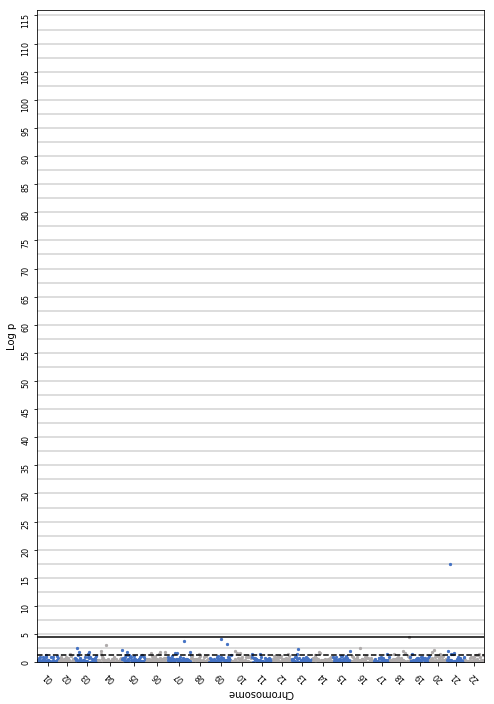

In [51]:
manhattanPlot(filtered)

<img src="manhattan.png">

In [52]:
## How many SNPs did you identify that exceeded the Bonferroni-level of significance?

signif = filtered[filtered['OR P'] < 0.05 / len(full_data)]

signif.describe()

,Min F C,Min F D,OR,OR P,HWE P,p_adj,ind
count,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.0
mean,0.073138,0.139389,2.052547,3.298698e-18,0.246728,17.481657,783.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.073138,0.139389,2.052547,3.298698e-18,0.246728,17.481657,783.0
25%,0.073138,0.139389,2.052547,3.298698e-18,0.246728,17.481657,783.0
50%,0.073138,0.139389,2.052547,3.298698e-18,0.246728,17.481657,783.0
75%,0.073138,0.139389,2.052547,3.298698e-18,0.246728,17.481657,783.0
max,0.073138,0.139389,2.052547,3.298698e-18,0.246728,17.481657,783.0


## How much can you trust your results

Typically, you want to examine the genome-wide distribution of your chi_square distribution against an expected null distribution. Visually you can do this using a quantile-quantile plot. Significant deviation from the null distribution may point to population stratification, familial relationships, technical bias, poor sample collection or sometimes even undetected sample duplications.
(Slide courtesy - Dr. Chirag Patel)

<img src="qqplot_example.png">


In [20]:
## Based on your results do a quantile-quantile plot for your data

##load your results 
##sort/order the -log10 of your p values in increasing order
##generate an expected set of -log10(p_values)
##plot the expected values on the x-axis and the observed -log10 (pvalues) on the y axis
##Alternatively use: p = observed p values
##stats.probplot(p, dist="norm", plot=pylab)
##pylab.show()


### Genomic Inflation Factor

Mathematically, you can correct for some of the deviation by computing an inflation factor and then correcting for this inflation factor. This quantity is termed as genomic inflation factor ($\lambda$)

$\lambda$ = observed median of test statistic distribution / expected median of the test statistic 
distribution.  For 1 degree of freedom, the X2 distribution has an expected median of 0.455

$\lambda$ <= 1.05 is considered acceptable. >1.1 is troubling, and indicates there is some inflation of the p values.


In [ ]:
## Compute the genomic inflation factor

##labmda =  median(CHI2)/qchisq(0.5, 1)
##if (gif > 1.05), correct your computed Chi.square values and recompute the p_values
##chi2_corrected = CHI2/lambda, 
##pval_corrected = pchisq(chi2_corrected, 1, lower.tail = F)
##re-draw the qqplot using the corrected pvalues (pval_corrected)


## What does this mean?

Identify a SNP that is significant (above the Bonferroni threshold). 
What is the p-value of association and odds ratio for the SNP?
What is the interpretation of the odds ratio? 
What gene is this SNP associated with and its putative function in your disease pathogenesis? 


## Polygenic Risk Scores (PRS)

A PRS is the cumulative risk of all SNP for a single patient. For example, if a patient has a 2 snps with OR=2 each, then their PRS is 4. The underlying assumption here is that each allele has an equal contribution and there is no interation between SNPS, that is the SNPS are independent. 

$prs =\sum_{i=1}^{m}-log_{10}(x_i) \cdot n_i$